In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import scipy

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device = torch.device(device)
print('Using {} device'.format(device))
#device = torch.device("cpu")

Using mps device


In [3]:
X_test = np.load("X_test.npy")
# X_test = scipy.stats.zscore(X_test, axis=1)
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
# X_train_valid = scipy.stats.zscore(X_train_valid, axis=1)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")
y_test -= 769
y_train_valid -= 769

In [4]:
idx_val = np.random.choice(2115, 423, replace=False)
idx_tra = np.array(list(set(range(2115)).difference(set(idx_val))))
X_train, X_val = X_train_valid[idx_tra], X_train_valid[idx_val] 
y_train, y_val = y_train_valid[idx_tra], y_train_valid[idx_val]

### Shape of data

In [5]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


# To torch.tensor

In [6]:
X_train = torch.from_numpy(X_train).float()
X_train = X_train[:,None,:,:]
y_train = torch.from_numpy(y_train).long()
X_val = torch.from_numpy(X_val).float()
X_val = X_val[:,None,:,:]
y_val = torch.from_numpy(y_val).long()
X_test = torch.from_numpy(X_test).float()
X_test = X_test[:,None,:,:]
y_test = torch.from_numpy(y_test).long()

# Dataset Class

In [7]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Network

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        #nn.Conv2d(in_channels, out_channels, kernel_size)
        #input:(C,H,W)=(1,22,1000)
        
        self.conv1 = nn.Conv2d(1, 32, (1,64), padding='same') #(32,22,1000)
        self.bn1   = nn.BatchNorm2d(32) #(32,22,500)
        
        self.conv2 = nn.Conv2d(32, 64, (22,1)) #(64,1,1000)
        self.bn2   = nn.BatchNorm2d(64) #(64,1,1000) 
        #--->ELU()
        self.pool1 = nn.AvgPool2d([1, 5], stride=[1, 5], padding=0) #(64,1,200)
        
        self.conv3 = nn.Conv2d(64, 64, (1,16), padding='same') #(64,1,250)
        self.conv4 = nn.Conv2d(64, 64, (1,1), padding='same') #(64,1,250)
        self.bn3   = nn.BatchNorm2d(64) #(64,1,250)
        #--->ELU()
        self.pool2 = nn.AvgPool2d([1, 5], stride=[1, 5], padding=0) #(64,1,40)
        
        self.fc1 = nn.Linear(64*1*40,256)
        self.fc2 = nn.Linear(256,4)
        
        self.sm = nn.Softmax(dim=1)
        
        #non-linear
        self.nonlinear = nn.ELU(True)
        #Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        
        x = self.bn1(self.conv1(x))
        
        x = self.nonlinear(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout(x)
        
        x = self.nonlinear(self.bn3(self.conv4(self.conv3(x))))
        x = self.pool2(x)
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        # x = self.sm(x)
        return x

In [10]:
def train_epoch(model, optimizer, criterion, dataloader):
    train_loss = 0
    train_acc = 0
    model.train()
    for i, (inp, labels) in enumerate(dataloader):
        inp, labels = inp.to(device), labels.to(device)
        optimizer.zero_grad()
        outp = model(inp)
        outp_pred = torch.max(outp,axis=1).indices
        train_acc += torch.sum(outp_pred == labels)
        loss = criterion(outp, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_dataloader.dataset)
    train_acc = train_acc/ len(train_dataloader.dataset)
    return train_loss, train_acc

In [11]:
def predict(model, optimizer, criterion, dataloader, pred_loader=test_dataloader):
    test_loss = 0
    test_acc = 0
    best_acc = 0
    model.eval()
    with torch.no_grad():
        for i, (inp, labels) in enumerate(pred_loader):
            inp, labels = inp.to(device), labels.to(device)
            outp = model(inp)
            outp_pred = torch.max(outp,axis=1).indices
            test_acc += torch.sum(outp_pred == labels)
            loss = criterion(outp, labels)
            test_loss += loss.item()
        test_loss = test_loss / len(pred_loader.dataset)
        test_acc = test_acc / len(pred_loader.dataset)
    return test_loss, test_acc

In [12]:
acc_device = torch.device('cpu')
def run(num_epochs, optimizer, criterion, pred_loader=test_dataloader):
    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []
    best_acc = 0
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, criterion, train_dataloader)
        test_loss, test_acc = predict(model, optimizer, criterion, pred_loader)
        # if epoch % 5 == 0:
        #     print(f'Epoch [{epoch+1}], train_Loss : {train_loss:.4f}, val_Loss : {test_loss:.4f},\
        #         train_accuracy : {100*train_acc:.4f}%, val_accuracy : {100*test_acc:.4f}%')
        print(f'Epoch [{epoch+1}], train_Loss : {train_loss:.4f}, val_Loss : {test_loss:.4f},\
                train_accuracy : {100*train_acc:.4f}%, val_accuracy : {100*test_acc:.4f}%')
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        train_acc_list.append(train_acc.to(acc_device))
        test_acc_list.append(test_acc.to(acc_device))

        if test_acc > best_acc and pred_loader != test_dataloader:
            torch.save(model.state_dict(), 'CNN_2nd_update.pt')
            best_acc = test_acc
    return train_loss_list, test_loss_list, train_acc_list, test_acc_list

In [13]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [14]:
train_loss_list, test_loss_list, train_acc_list, test_acc_list = run(200, optimizer, criterion, val_dataloader)

/Users/hodaka/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678522338528/work/aten/src/ATen/native/Convolution.cpp:1004.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1], train_Loss : 0.0469, val_Loss : 0.0418,                train_accuracy : 33.9835%, val_accuracy : 33.8600%
Epoch [2], train_Loss : 0.0387, val_Loss : 0.0371,                train_accuracy : 44.2080%, val_accuracy : 49.8871%
Epoch [3], train_Loss : 0.0353, val_Loss : 0.0362,                train_accuracy : 50.7683%, val_accuracy : 52.8217%
Epoch [4], train_Loss : 0.0342, val_Loss : 0.0365,                train_accuracy : 54.1371%, val_accuracy : 48.0813%
Epoch [5], train_Loss : 0.0328, val_Loss : 0.0351,                train_accuracy : 56.2648%, val_accuracy : 49.8871%
Epoch [6], train_Loss : 0.0314, val_Loss : 0.0344,                train_accuracy : 58.9243%, val_accuracy : 51.2415%
Epoch [7], train_Loss : 0.0305, val_Loss : 0.0334,                train_accuracy : 59.4563%, val_accuracy : 57.3363%
Epoch [8], train_Loss : 0.0293, val_Loss : 0.0341,                train_accuracy : 61.7021%, val_accuracy : 55.3047%
Epoch [9], train_Loss : 0.0281, val_Loss : 0.0329,              

In [18]:
model = CNN().to(device)
model.load_state_dict(torch.load('CNN_2nd_update.pt'))
model.eval()
test_loss, test_acc = predict(model, optimizer, criterion, test_dataloader)

print(f'Test_Loss : {test_loss:.4f},Test_Accuracy : {100*test_acc:.4f}%')

Test_Loss : 0.0373,Test_Accuracy : 71.5576%


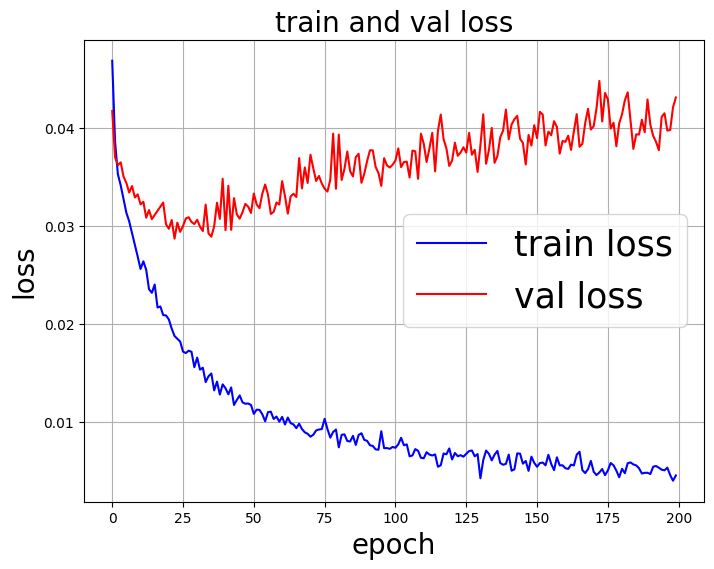

In [19]:
num_epochs = 200
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.plot(range(num_epochs), train_loss_list, c='b', label='train loss')
ax.plot(range(num_epochs), test_loss_list, c='r', label='val loss')
ax.set_xlabel('epoch', fontsize='20')
ax.set_ylabel('loss', fontsize='20')
ax.set_title('train and val loss', fontsize='20')
ax.grid()
ax.legend(fontsize='25')
plt.show()

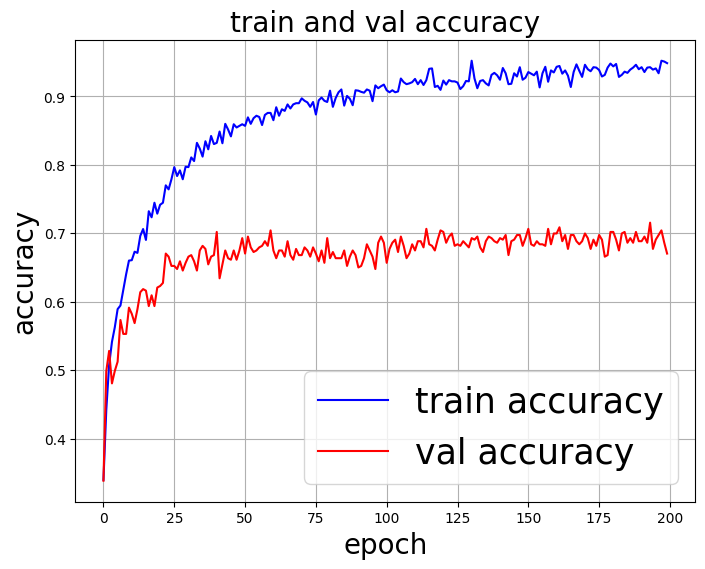

In [49]:
num_epochs = 200
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.plot(range(num_epochs), train_acc_list, c='b', label='train accuracy')
ax.plot(range(num_epochs), test_acc_list, c='r', label='val accuracy')
ax.set_xlabel('epoch', fontsize='20')
ax.set_ylabel('accuracy', fontsize='20')
ax.set_title('train and val accuracy', fontsize='20')
ax.grid()
ax.legend(fontsize='25')
plt.show()

In [21]:
from torchsummary import summary
model = CNN()
summary(model, (1, 22, 1000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 22, 1000]           2,080
       BatchNorm2d-2         [-1, 32, 22, 1000]              64
            Conv2d-3          [-1, 64, 1, 1000]          45,120
       BatchNorm2d-4          [-1, 64, 1, 1000]             128
               ELU-5          [-1, 64, 1, 1000]               0
         AvgPool2d-6           [-1, 64, 1, 200]               0
           Dropout-7           [-1, 64, 1, 200]               0
            Conv2d-8           [-1, 64, 1, 200]          65,600
            Conv2d-9           [-1, 64, 1, 200]           4,160
      BatchNorm2d-10           [-1, 64, 1, 200]             128
              ELU-11           [-1, 64, 1, 200]               0
        AvgPool2d-12            [-1, 64, 1, 40]               0
          Dropout-13            [-1, 64, 1, 40]               0
           Linear-14                  [